## Prorail project: Baseline Model

In [144]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import timedelta

from sklearn.linear_model import LinearRegression
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score 

import seaborn as sns

### Business understanding

##### Achtergrond:

**De doelstelling van het project is om de planners te helpen om de hervatting van het treinverkeer te organiseren. In de praktijk blijkt dat de voorspellingen van de monteurs vaak te pessimistisch zijn. De vraag van ProRail en de planners van de NS is of op basis van de data een betere voorspelling te maken is waardoor de dienstregeling sneller hervat kan worden. De voorspellingen moeten getoond worden in een dashboard waar relevante informatie over de voorspelling, zoals de betrouwbaarheid, getoond wordt.**

Er moet dus gekeken worden naar de tijd voor het oplossen van een probleem. Dit kan gedaan worden door als target het gemiddelde te pakken en daarmee een voorspelling te doen voor aankomende meldingen. We kunnen als vraag hebben:"De reparatietijd is altijd gelijk aan de gemiddelde reparatietijd."

Deze voorspelling moet helpen voor Reizigers, om ze een inschatting te geven hoe lang een probleem gaat duren. Om dat goed te visualiseren wordt eerst de voorspelling gegeven aan een reizigerplanner van de NS/ProRail, want tegenwoordig wordt die voorspelling gedaan met de losse vinger door de aannemers. Deze is meestal erg hoog ingeschat of laag ingeschat, wegens het opmerken/negeren van onverwachtse problemen die kunnen gebeuren. Dat geeft de reiziger veel verwarring en kost veel tijd en geld. Dat moet automatisch en beter kunnen.

##### Doelen:

Om de reparatietijd in te schatten kan je kijken naar de eerder voorkomende meldingen. In dit geval de 0.9 miljoen rijen aan meldingen data. Om daar een beginnetje te maken, gaan we de vraag beantwoorden: "De reparatietijd is altijd gelijk aan de gemiddelde reparatietijd.". Als je de betrouwbaarheid berekend kan je dat gebruiken om accurater de reparatietijd te bepalen.
Toch zal dit op elke plaats en tijd anders zijn dan voorspelt. De plaats kan namelijk lastig bereikbaar zijn of midden in de nacht zijn. Daarnaast werkt de Data ook niet mee. Zo zijn er tijdbepalingen van het bereiken van aannemers, willekeurig ingevoerd, zodat je soms aannemer tijden na de storing tijden krijg waardoor de reparatietijd negatief wordt.

##### Succes ratio:

Dus de programma van eisen in een paar woorden:  
**S**pecifiek: Reparatietijd bepalen voor reizigers  
**M**eetbaar: Gebruik gemaakt van vorige meldingen Data  
**A**cceptabel: Het hebben van een voorspelling geeft de planners voldoening  
**R**ealistisch: Met de juiste Data en ingeschatte waardes is het haalbaar  
**T**ijdsgebonden: Zo snel mogelijk ingeschat worden (rond de 5 min)  

Deze voorspelling moet weergegeven worden in een applicatie (zie Userstory Application)

### Data understanding

Als we de oplostijd willen weten, moeten we beginnen met het hebben van alle tijdsduur van de melding. 

Dus de columns: 
stm_fh_duur (functie duur)
stm_progfh_in_duur (prognose duur)


<!-- We willen de hele process tijd weten totdat het mogelijk is om te rijden vanaf het moment dat het probleem in het systeem wordt vermeld, dus meldtijd is het begin. Het einde moet zijn wanneer de treinen officieel kunnen rijden dus officiele einde storing tijd. 

Dan komen deze columns daaruit:   stm_sap_meld_ddt (meldtijd), stm_sap_storeind_ddt (officiele einde storing tijd), stm_sap_meldtijd (meldtijd), stm_sap_storeindtijd (officiele einde storing tijd)

Deze kolommen hebben dezelfde beschrijving dus de keuze wordt gemaakt bij Data preperation. -->

In [147]:
read_data = pd.read_csv('pro-rails_data.csv')

In [ ]:
oplostijd_data = read_data[['stm_fh_duur', 'stm_progfh_in_duur']]
oplostijd_data.dtypes

Uit de dtypes kan je zien de prognosetijd een object (string waarschijnlijk) is. Wat betekent dat deze kolom niet gebruikt wordt om te rekenen. Dus de overgebleven kolom stm_fh_duur is de beste, want het geeft de duur van de melding (in minuten) weer

In [ ]:
oplostijd_data = pd.DataFrame(oplostijd_data['stm_fh_duur'])
oplostijd_data

Nu gaan we dataset kolommen erbij pakken die helpen als features en duplicates eruit te halen. De features zijn: stm_oorz_groep (Oorzaakgroep), stm_geo_gst (Geocode) en tijdstip (stm_sap_meld_ddt). De anti-duplicate kolom is: #stm_sap_meldnr (Meldnummer). Ook moeten de sterke uitschieters van de reparatietijd uit de data.

In [ ]:
useful_data= read_data[['#stm_sap_meldnr', 'stm_fh_duur', 'stm_geo_mld', 'stm_prioriteit', 'stm_oorz_groep']]
useful_data

Om deze data bruikbaar te maken, moet er ten eerste alle duplicates eruit. Wat je kan droppen met #stm_sap_meldnr

In [ ]:
useful_data = useful_data.drop_duplicates(subset=['#stm_sap_meldnr'])
useful_data

In [ ]:
useful_data.boxplot(column=['stm_fh_duur'])

Dat ziet er niet goed uit. Nu de Extreem sterke uitschieters eruit halen

In [ ]:
useful_data= useful_data.dropna(how = 'all') 
useful_data = useful_data.reset_index(drop=True)
Q1 = useful_data['stm_fh_duur'].quantile(0.25)
Q3 = useful_data['stm_fh_duur'].quantile(0.75)
IQR = Q3 - Q1
print(IQR)

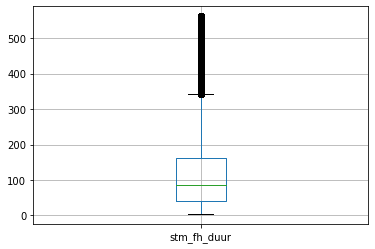

In [160]:
only_duur = useful_data['stm_fh_duur']
useful_data['strong_outlier'] = ((only_duur < (Q1 - 1.5 * IQR)) | (only_duur > (Q3 + 1.5 * IQR))) #create temporary column
useful_data = useful_data.drop(useful_data[useful_data.strong_outlier == True].index)

useful_data =  useful_data.drop('strong_outlier', 1)

useful_data.boxplot(column=['stm_fh_duur'])

Een reparatietijd van 0 minuten kan natuurlijk niet. Laten we kijken hoeveel meldingen ook zo'n lage reparatietijd heeft

In [ ]:
countings = pd.DataFrame(useful_data['stm_fh_duur'].value_counts())
countings = countings.reset_index()
countings = countings.sort_values(by=['index'])
countings

Een melding die 3 minuten duurt, hoef geen aannemer wordeng gebeld. Laten we die rijen verwijderen

In [ ]:
useful_data = useful_data.drop(useful_data[useful_data.stm_fh_duur < 4].index)
useful_data

Na al deze bewerkingen kloppen natuurlijk de indexes niet meer dus die worden gereset

In [ ]:
useful_data= useful_data.dropna(how = 'all') 
useful_data = useful_data.reset_index(drop=True)
useful_data

Daarna kan je dan de onbekende (nans) verwijderen om ValueErrors te voorkomen. Toch kunnen we later met maar een aantal kolommen toch te werk gaan. Dus maken we een nieuwe dataframe die Nan proof is voor later

In [ ]:
useful_data.isna().sum()

In [ ]:
useful_data_Nan_proof = useful_data.dropna()
useful_data_Nan_proof = useful_data_Nan_proof.reset_index(drop=True)
useful_data_Nan_proof

Om later natuurlijk makkelijker te werken met de dates moet de type omgezet worden naar datetime. In dit geval alleen voor'stm_sap_meld_ddt'

In [ ]:
# useful_data['stm_sap_meld_ddt'] = pd.to_datetime(useful_data['stm_sap_meld_ddt'])
# useful_data.dtypes

In [ ]:
# df.isnull().sum()

TADA, de perfecte dataset

### Data preparation

In [ ]:
useful_data_Nan_proof['stm_fh_duur'].mean()

In [ ]:
pd.DataFrame(useful_data_Nan_proof['stm_fh_duur'].value_counts())

Om te kijken welke kolommen een verband (correlatie) met elkaar hebben, gaan we describe gebruiken

In [ ]:
useful_data.corr()

In [ ]:
useful_data.describe()

### Sprint 1 baseline model code:

### Baseline model gemaakt zonder cleaning
boxplot om te kijken hoe ver data van elkaar ligt

In [ ]:
oplostijd_data = oplostijd_data.dropna()
oplostijd_data.boxplot(column=['stm_fh_duur'])

Gemiddelde wordt berekent en als kolom toegevoegd

In [ ]:
gemiddelde_oplostijd = oplostijd_data['stm_fh_duur'].mean()
gemiddelde_oplostijd = round(float(str(gemiddelde_oplostijd)[15:25]))
print("Gemiddelde: " + str(gemiddelde_oplostijd) + " minuten")
oplostijd_data['gemiddelde'] = gemiddelde_oplostijd
oplostijd_data.describe()

Nan's worden gedropt en "hoe ver van gemiddelde af" kolom


In [ ]:

oplostijd_data['close_to_mean'] = oplostijd_data['stm_fh_duur'] - gemiddelde_oplostijd
oplostijd_data

In [ ]:
# source: https://stackoverflow.com/questions/30112202/how-do-i-find-the-closest-values-in-a-pandas-series-to-an-input-number
closest_mean_data = oplostijd_data.iloc[(oplostijd_data['close_to_mean']- 0).abs().argsort()]
closest_mean_data

### error scores
##### - accuracy
##### - r2
##### - mean square

In [ ]:
on_mean_times = closest_mean_data[closest_mean_data.close_to_mean == 0].shape[0]
# print("{} waardes zijn gelijk aan het gemiddelde, {} is het aantal waardes dus {}% van de waardes is gelijk aan de gemiddelde reparatietijd".format(on_mean_times, len(closest_mean_data), on_mean_times/len(closest_mean_data)*100))
print("{} waardes gelijk aan gemiddelde , {} totaal waardes & {}% gelijk aan de gemiddelde reparatietijd".format(on_mean_times, len(closest_mean_data), on_mean_times/len(closest_mean_data)*100))

In [ ]:
r2_uncleaned = r2_score(closest_mean_data['gemiddelde'], closest_mean_data['stm_fh_duur'])
r2_uncleaned

In [ ]:
sq_error_uncleaned = mean_squared_error(closest_mean_data['gemiddelde'], closest_mean_data['stm_fh_duur'], squared=False)
sq_error_uncleaned

### Baseline model gemaakt met cleaning
Boxplot was gedaan om te kijken hoe ver de data van elkaar ligt

In [149]:
useful_data_mean = useful_data.dropna(subset=['stm_fh_duur'])
useful_data_mean

#stm_sap_meldnr  stm_fh_duur  stm_geo_mld  stm_prioriteit  \
0            50053213.0         51.0         25.0             9.0   
1            50053214.0         40.0         12.0             9.0   
2            50053215.0          6.0        614.0             9.0   
3            50053218.0          7.0        551.0             9.0   
4            50053219.0         13.0         17.0             9.0   
...                 ...          ...          ...             ...   
349623       99003501.0         63.0        104.0             2.0   
349624       99003504.0         25.0        158.0             5.0   
349625       99003505.0         83.0        560.0             5.0   
349626       99003506.0         83.0        468.0             2.0   
349627       99999999.0         19.0        102.0             2.0   

       stm_oorz_groep  
0            ONR-DERD  
1            ONR-DERD  
2            ONR-DERD  
3             TECHONV  
4            ONR-DERD  
...               ...  
349623        TECHONV  
349624        TECHONV  
349625        TECHONV  
349626        TECHONV  
349627        ONR-RIB  

[349628 rows x 5 columns]

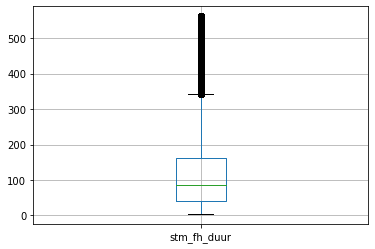

In [150]:

useful_data_mean.boxplot(column=['stm_fh_duur'])

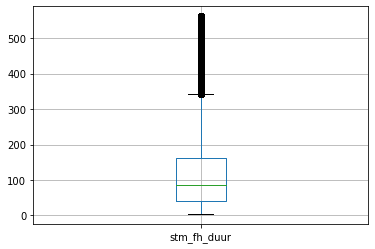

In [151]:
useful_data_Nan_proof.boxplot(column=['stm_fh_duur'])

In [152]:
useful_data_mean

#stm_sap_meldnr  stm_fh_duur  stm_geo_mld  stm_prioriteit  \
0            50053213.0         51.0         25.0             9.0   
1            50053214.0         40.0         12.0             9.0   
2            50053215.0          6.0        614.0             9.0   
3            50053218.0          7.0        551.0             9.0   
4            50053219.0         13.0         17.0             9.0   
...                 ...          ...          ...             ...   
349623       99003501.0         63.0        104.0             2.0   
349624       99003504.0         25.0        158.0             5.0   
349625       99003505.0         83.0        560.0             5.0   
349626       99003506.0         83.0        468.0             2.0   
349627       99999999.0         19.0        102.0             2.0   

       stm_oorz_groep  
0            ONR-DERD  
1            ONR-DERD  
2            ONR-DERD  
3             TECHONV  
4            ONR-DERD  
...               ...  
349623        TECHONV  
349624        TECHONV  
349625        TECHONV  
349626        TECHONV  
349627        ONR-RIB  

[349628 rows x 5 columns]

Gemiddelde wordt berekent en als kolom toegevoegd

In [153]:
gemiddelde_oplostijd = useful_data_mean['stm_fh_duur'].mean()
gemiddelde_oplostijd = round(float(str(gemiddelde_oplostijd)))
print("Gemiddelde: " + str(gemiddelde_oplostijd) + " minuten")
useful_data_mean['gemiddelde'] = gemiddelde_oplostijd
useful_data_mean


Gemiddelde: 122 minuten


#stm_sap_meldnr  stm_fh_duur  stm_geo_mld  stm_prioriteit  \
0            50053213.0         51.0         25.0             9.0   
1            50053214.0         40.0         12.0             9.0   
2            50053215.0          6.0        614.0             9.0   
3            50053218.0          7.0        551.0             9.0   
4            50053219.0         13.0         17.0             9.0   
...                 ...          ...          ...             ...   
349623       99003501.0         63.0        104.0             2.0   
349624       99003504.0         25.0        158.0             5.0   
349625       99003505.0         83.0        560.0             5.0   
349626       99003506.0         83.0        468.0             2.0   
349627       99999999.0         19.0        102.0             2.0   

       stm_oorz_groep  gemiddelde  
0            ONR-DERD         122  
1            ONR-DERD         122  
2            ONR-DERD         122  
3             TECHONV         122  
4            ONR-DERD         122  
...               ...         ...  
349623        TECHONV         122  
349624        TECHONV         122  
349625        TECHONV         122  
349626        TECHONV         122  
349627        ONR-RIB         122  

[349628 rows x 6 columns]

In [154]:
useful_data_mean['close_to_mean'] = useful_data_mean['stm_fh_duur'] - gemiddelde_oplostijd
useful_data_mean

#stm_sap_meldnr  stm_fh_duur  stm_geo_mld  stm_prioriteit  \
0            50053213.0         51.0         25.0             9.0   
1            50053214.0         40.0         12.0             9.0   
2            50053215.0          6.0        614.0             9.0   
3            50053218.0          7.0        551.0             9.0   
4            50053219.0         13.0         17.0             9.0   
...                 ...          ...          ...             ...   
349623       99003501.0         63.0        104.0             2.0   
349624       99003504.0         25.0        158.0             5.0   
349625       99003505.0         83.0        560.0             5.0   
349626       99003506.0         83.0        468.0             2.0   
349627       99999999.0         19.0        102.0             2.0   

       stm_oorz_groep  gemiddelde  close_to_mean  
0            ONR-DERD         122          -71.0  
1            ONR-DERD         122          -82.0  
2            ONR-DERD         122         -116.0  
3             TECHONV         122         -115.0  
4            ONR-DERD         122         -109.0  
...               ...         ...            ...  
349623        TECHONV         122          -59.0  
349624        TECHONV         122          -97.0  
349625        TECHONV         122          -39.0  
349626        TECHONV         122          -39.0  
349627        ONR-RIB         122         -103.0  

[349628 rows x 7 columns]

In [155]:
useful_data_mean = useful_data_mean.sort_values(by='close_to_mean', ascending=False)
useful_data_mean

#stm_sap_meldnr  stm_fh_duur  stm_geo_mld  stm_prioriteit  \
152736       80558671.0        562.0        603.0             5.0   
101434       80472067.0        562.0        663.0             5.0   
183271       80608078.0        562.0         53.0             5.0   
120779       80504799.0        562.0        516.0             5.0   
140307       80538105.0        562.0        531.0             5.0   
...                 ...          ...          ...             ...   
329970       80873811.0          4.0        506.0             4.0   
79172        80434947.0          4.0        924.0             4.0   
201164       80637445.0          4.0        531.0             4.0   
337758       80895338.0          4.0        531.0             2.0   
331678       80877655.0          4.0        508.0             5.0   

       stm_oorz_groep  gemiddelde  close_to_mean  
152736        TECHONV         122          440.0  
101434        TECHONV         122          440.0  
183271        TECHONV         122          440.0  
120779        TECHONV         122          440.0  
140307        ONR-RIB         122          440.0  
...               ...         ...            ...  
329970        TECHONV         122         -118.0  
79172         TECHONV         122         -118.0  
201164        TECHONV         122         -118.0  
337758           WEER         122         -118.0  
331678        TECHONV         122         -118.0  

[349628 rows x 7 columns]

In [156]:
closest_mean_data = useful_data_mean.iloc[(useful_data_mean['close_to_mean']- 0).abs().argsort()]
closest_mean_data

#stm_sap_meldnr  stm_fh_duur  stm_geo_mld  stm_prioriteit  \
260676       80735849.0        122.0        626.0             5.0   
135936       80531111.0        122.0        542.0             2.0   
117470       80499165.0        122.0        105.0             2.0   
68300        80417407.0        122.0         17.0             2.0   
125320       80512520.0        122.0        555.0             4.0   
...                 ...          ...          ...             ...   
312709       80835860.0        562.0        531.0             4.0   
301985       80814010.0        562.0        509.0             9.0   
183692       80608802.0        562.0          4.0             5.0   
218453       80665243.0        562.0        517.0             5.0   
152736       80558671.0        562.0        603.0             5.0   

       stm_oorz_groep  gemiddelde  close_to_mean  
260676        TECHONV         122            0.0  
135936        TECHONV         122            0.0  
117470        TECHONV         122            0.0  
68300            WEER         122            0.0  
125320        TECHONV         122            0.0  
...               ...         ...            ...  
312709        ONR-RIB         122          440.0  
301985           WEER         122          440.0  
183692        TECHONV         122          440.0  
218453        TECHONV         122          440.0  
152736        TECHONV         122          440.0  

[349628 rows x 7 columns]

### error scores
##### - accuracy
##### - r2
##### - mean square

In [161]:
r2_cleaned = r2_score(closest_mean_data['gemiddelde'], closest_mean_data['stm_fh_duur'])
r2_cleaned


0.0

In [162]:
sq_error_cleaned = mean_squared_error(closest_mean_data['gemiddelde'], closest_mean_data['stm_fh_duur'], squared=False)
sq_error_cleaned

113.33654155219284

### Linear Regression

In [163]:
useful_data = useful_data.dropna()
useful_data

#stm_sap_meldnr  stm_fh_duur  stm_geo_mld  stm_prioriteit  \
0            50053213.0         51.0         25.0             9.0   
1            50053214.0         40.0         12.0             9.0   
2            50053215.0          6.0        614.0             9.0   
3            50053218.0          7.0        551.0             9.0   
4            50053219.0         13.0         17.0             9.0   
...                 ...          ...          ...             ...   
349623       99003501.0         63.0        104.0             2.0   
349624       99003504.0         25.0        158.0             5.0   
349625       99003505.0         83.0        560.0             5.0   
349626       99003506.0         83.0        468.0             2.0   
349627       99999999.0         19.0        102.0             2.0   

       stm_oorz_groep  
0            ONR-DERD  
1            ONR-DERD  
2            ONR-DERD  
3             TECHONV  
4            ONR-DERD  
...               ...  
349623        TECHONV  
349624        TECHONV  
349625        TECHONV  
349626        TECHONV  
349627        ONR-RIB  

[349628 rows x 5 columns]

In [164]:
# for c, i in enumerate(useful_data['stm_geo_mld']):
#     try:
#         useful_data.at[c, 'stm_geo_mld'] = int(float(i))
#     except:
#         useful_data.drop([c], inplace=True)
        
# useful_data = useful_data.reset_index(drop=True)

In [165]:
# useful_data_test = useful_data.copy()
# useful_data_test[["stm_geo_mld"]] = useful_data_test[["stm_geo_mld"]].apply(pd.to_numeric)
# useful_data_test[["stm_geo_mld"]] = useful_data_test[["stm_geo_mld"]].astype(float) 
# useful_data_test.dtypes
# useful_data = useful_data_test 

In [166]:

useful_data = useful_data.dropna()
useful_data

#stm_sap_meldnr  stm_fh_duur  stm_geo_mld  stm_prioriteit  \
0            50053213.0         51.0         25.0             9.0   
1            50053214.0         40.0         12.0             9.0   
2            50053215.0          6.0        614.0             9.0   
3            50053218.0          7.0        551.0             9.0   
4            50053219.0         13.0         17.0             9.0   
...                 ...          ...          ...             ...   
349623       99003501.0         63.0        104.0             2.0   
349624       99003504.0         25.0        158.0             5.0   
349625       99003505.0         83.0        560.0             5.0   
349626       99003506.0         83.0        468.0             2.0   
349627       99999999.0         19.0        102.0             2.0   

       stm_oorz_groep  
0            ONR-DERD  
1            ONR-DERD  
2            ONR-DERD  
3             TECHONV  
4            ONR-DERD  
...               ...  
349623        TECHONV  
349624        TECHONV  
349625        TECHONV  
349626        TECHONV  
349627        ONR-RIB  

[349628 rows x 5 columns]

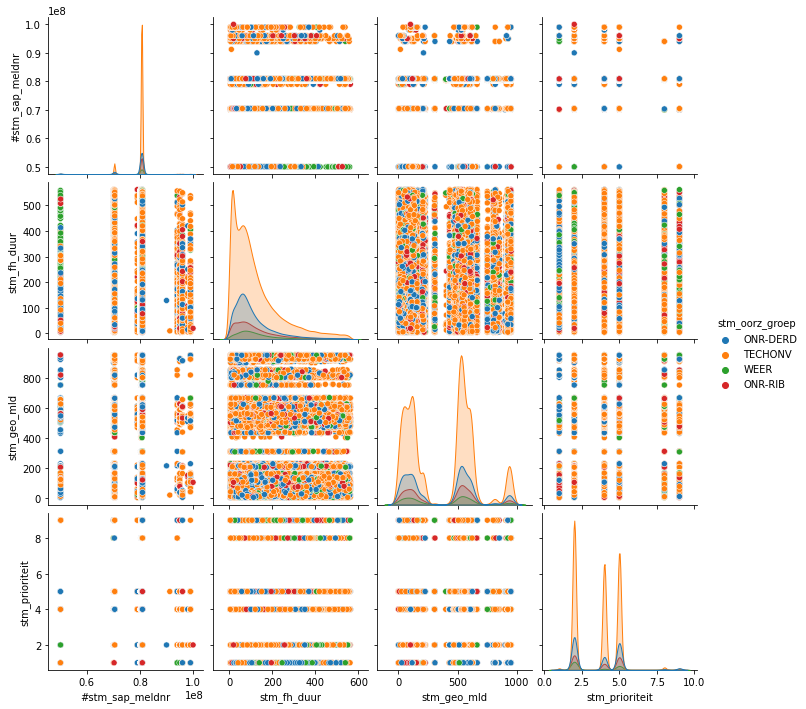

In [167]:
sns.pairplot(useful_data,hue='stm_oorz_groep')

In [168]:
useful_data.corr()

#stm_sap_meldnr  stm_fh_duur  stm_geo_mld  stm_prioriteit
#stm_sap_meldnr         1.000000     0.005548     0.058074       -0.099376
stm_fh_duur             0.005548     1.000000    -0.000788        0.183392
stm_geo_mld             0.058074    -0.000788     1.000000       -0.007723
stm_prioriteit         -0.099376     0.183392    -0.007723        1.000000

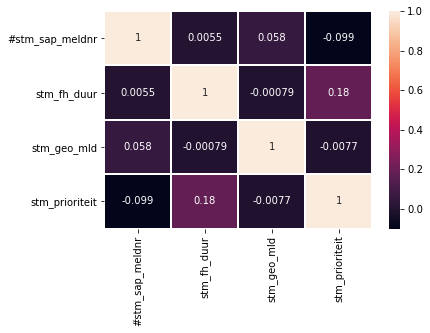

In [169]:
sns.heatmap(useful_data.corr(),annot=True,lw=1)

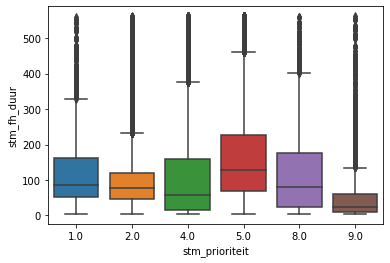

In [170]:
sns.boxplot(y='stm_fh_duur',x='stm_prioriteit',data=useful_data)

In [171]:
DummiesX = pd.get_dummies(data=useful_data[['stm_geo_mld', 'stm_prioriteit', 'stm_oorz_groep']])
DummiesX.head()

stm_geo_mld  stm_prioriteit  stm_oorz_groep_ONR-DERD  \
0         25.0             9.0                        1   
1         12.0             9.0                        1   
2        614.0             9.0                        1   
3        551.0             9.0                        0   
4         17.0             9.0                        1   

   stm_oorz_groep_ONR-RIB  stm_oorz_groep_TECHONV  stm_oorz_groep_WEER  
0                       0                       0                    0  
1                       0                       0                    0  
2                       0                       0                    0  
3                       0                       1                    0  
4                       0                       0                    0

In [172]:
DummiesY = useful_data[['stm_fh_duur']]
# DummiesY = DummiesY.dropna()
DummiesY

stm_fh_duur
0              51.0
1              40.0
2               6.0
3               7.0
4              13.0
...             ...
349623         63.0
349624         25.0
349625         83.0
349626         83.0
349627         19.0

[349628 rows x 1 columns]

In [173]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(DummiesX, DummiesY, test_size=0.4, random_state=101)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(209776, 6)
(139852, 6)
(209776, 1)
(139852, 1)


In [174]:
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train,y_train)

LinearRegression()

In [175]:
predictions = model.predict(X_test)
predictions

array([[ 94.06161757],
       [141.4864196 ],
       [141.49148266],
       ...,
       [141.43087925],
       [122.42436092],
       [ 98.83843492]])

d:\users\ruben\appdata\local\programs\python\python37\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


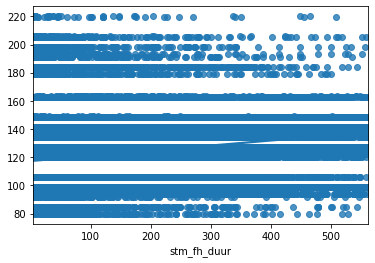

In [176]:
sns.regplot(y_test,predictions)

In [177]:
r2_score(y_test ,predictions)

0.03687700320585385

In [178]:
mean_squared_error(y_test, predictions, squared=False)

111.23255248741799